In [ ]:
%pip install jaxtyping transformer_lens einops

In [2]:
# SETUP

import os
import sys
from functools import partial
from pathlib import Path

import einops
import numpy as np
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from huggingface_hub import hf_hub_download
from jaxtyping import Float
from torch import Tensor
from tqdm.notebook import tqdm
from transformer_lens import HookedTransformer, HookedTransformerConfig
from transformer_lens.utils import to_numpy
from copy import deepcopy
import pandas as pd

device = t.device("cuda" if t.cuda.is_available() else "cpu")
print(device)

MAIN = __name__ == "__main__"

cpu


In [3]:
# CREATING DATASET

def create_dataset(p, train_fraction, seed, run_dir):
    # Generating dataset
    x = t.arange(p)
    y = t.arange(p)
    # All combinations of x and y where x and y are all numbers from 0 to 112
    grid_x, grid_y = t.meshgrid(x, y, indexing = "ij")
    # Flattening grid from 113 x 113 to 12769 x 1
    flat_x = grid_x.flatten()
    flat_y = grid_y.flatten()
    # 113 is the equals token
    equals_col = t.full_like(flat_x, p)

    # Dataset is of shape (12769, 3), where each row is (x, y, 113)
    dataset = t.stack([flat_x, flat_y, equals_col], dim = 1).to(device)

    # Computing actual answers (labels)
    labels = (flat_x + flat_y) % p
    labels = labels.to(device)

    gen = t.Generator(device = "cpu").manual_seed(seed)
    indices = t.randperm(len(dataset), generator = gen)

    split = int(len(dataset) * train_fraction)
    train_indices = indices[:split]
    test_indices = indices[split:]

    # Save train/test split info if not called by linear probing or activation patching cell
    if run_dir != "probe":
        t.save(
            {
                "train_indices": train_indices.cpu(),
                "test_indices": test_indices.cpu(),
            },
            run_dir / "split.pt"
        )

    return dataset, labels, train_indices, test_indices

In [4]:
# MODEL SETUP

def create_model(p, seed):
    cfg = HookedTransformerConfig(
        n_layers = 1,
        d_model = 128,
        d_head = 32,
        n_heads = 4,
        d_vocab = p + 1,
        n_ctx = 3,
        act_fn = "relu",
        normalization_type = None,
        d_mlp = 512,
        # Different seed to measure how different initializations affect grokking
        seed = seed
    )

    return cfg

In [5]:
# EVALUATION FUNCTION

def eval_split(model, dataset, labels, indices):
    logits = model(dataset[indices])[:, -1, :]
    loss = F.cross_entropy(logits, labels[indices]).item()
    acc = (logits.argmax(dim = 1) == labels[indices]).float().mean().item()
    return loss, acc

In [6]:
# TRAINING LOOP

def train_model(model_seed, split_seed, run_dir, dataset, labels, train_indices, test_indices, train_fraction):
    t.manual_seed(model_seed)
    # Reinitialize model to avoid issues with re-running cells
    cfg = create_model(113, model_seed)
    model = HookedTransformer(cfg).to(device)
    # Save model before training for later comparison
    t.save(model.state_dict(), run_dir / f"pre_grok_model.pt")

    # Weight decay to encourage simpler models that generalize better
    optimizer = optim.AdamW(model.parameters(), lr = 1e-3, weight_decay = 1.0)

    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    # High number of epochs to allow for grokking
    epochs = 10000

    best_pre_epoch = None
    grok_epoch = None

    for epoch in tqdm(range(epochs)):
        model.train()
        # Forward pass
        train_logits = model(dataset[train_indices])[:, -1, :]

        # Backward pass, calculate loss
        train_loss = F.cross_entropy(train_logits, labels[train_indices])
        train_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if epoch % 100 == 0:
            model.eval()
            with t.inference_mode():
                # Recompute train loss for logging
                train_loss, train_acc = eval_split(model, dataset, labels, train_indices)
                # Check test
                test_loss, test_acc = eval_split(model, dataset, labels, test_indices)

                # Update logs and print progress
                train_losses.append(train_loss)
                train_accuracies.append(train_acc)
                test_losses.append(test_loss)
                test_accuracies.append(test_acc)

        # Save model before grokking for later comparison
        if test_acc <= 0.15:
            best_pre_epoch = epoch
            t.save(model.state_dict(), run_dir / f"mid_grok_model.pt")

        if test_acc >= 0.99:
            if (grok_epoch == None):
                grok_epoch = epoch

    # Save grok_epoch and best_pre_epoch to file
    training_data = pd.DataFrame({
        "model_seed": [model_seed],
        "split_seed": [split_seed],
        "train_fraction": [train_fraction],
        "mid_epoch": [best_pre_epoch],
        "grok_epoch": [grok_epoch],
    })
    csv_path = Path("runs") / "events.csv"
    csv_path.parent.mkdir(parents=True, exist_ok=True)
    write_header = not csv_path.exists()
    training_data.to_csv(csv_path, mode = "a", header = write_header, index = False)

    # Save final model after training
    t.save(model.state_dict(), run_dir / f"grok_model.pt")

    return train_losses, test_losses, train_accuracies, test_accuracies

In [7]:
# PLOTTING RESULTS

import matplotlib.pyplot as plt

def plot_results(train_losses, test_losses, test_accuracies, run_dir):
    log_freq = 100
    x_axis = np.arange(len(train_losses)) * log_freq

    # Loss plot
    plt.figure(figsize = (10, 6))
    plt.plot(x_axis, train_losses, label = "Train Loss", color = "blue")
    plt.plot(x_axis, test_losses, label = "Test Loss", color = "red")
    plt.yscale("log")
    plt.xlabel("Epochs")
    plt.ylabel("Loss (Log Scale)")
    plt.title("Grokking: Memorization vs Generalization")
    plt.legend()
    plt.grid(True, alpha = 0.3)
    plt.savefig(run_dir / f"grokking_loss.png")

    # Accuracy plot
    # Converting accuracy to percentage
    accuracy_percent = [acc * 100 for acc in test_accuracies]

    plt.figure(figsize = (10, 6))
    plt.plot(x_axis, accuracy_percent, label = "Test Accuracy", color = "green")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Grokking: Test Set Accuracy Over Time")
    plt.legend()
    plt.grid(True, alpha = 0.3)
    plt.savefig(run_dir / f"grokking_accuracy.png")

In [8]:
# ANALYSIS

from random import seed
from sklearn.decomposition import PCA

def analyze_model(seed, run_dir):
    # Load models at different stages of training to compare
    pre_model = HookedTransformer(create_model(113, seed)).to(device)
    mid_model = HookedTransformer(create_model(113, seed)).to(device)
    post_model = HookedTransformer(create_model(113, seed)).to(device)
    pre_model.load_state_dict(t.load(run_dir / f"pre_grok_model.pt"))
    mid_model.load_state_dict(t.load(run_dir / f"mid_grok_model.pt"))
    post_model.load_state_dict(t.load(run_dir / f"grok_model.pt"))

    models = {
        "Pre": pre_model,
        "Mid": mid_model,
        "Post": post_model,
    }

    for name, model in models.items():
        # Get weights
        weights = model.W_E[:-1].detach().cpu()

        # PCA, finding two most important components (dimensions) in 128-D embedding space
        pca = PCA(n_components = 2)
        pca_results = pca.fit_transform(weights)

        plt.figure(figsize = (8, 8))
        plt.scatter(pca_results[:, 0], pca_results[:, 1], c = range(113), cmap = "hsv")
        plt.colorbar(label = "Number (0 - 112)")
        plt.title(f"PCA of {name}-training Model")
        plt.xlabel("Principal Component 1")
        plt.ylabel("Principal Component 2")
        plt.savefig(run_dir / f"{name}_PCA.png")

        # Fourier transform
        fft = t.fft.rfft(weights, dim = 0)
        # Finding magnitudes of neuron weights
        fft_magnitude = fft.abs()

        plt.figure(figsize=(12, 6))
        # .T plots neurons on Y-axis (0-127) and frequencies on X-axis (0-56)
        plt.imshow(fft_magnitude.T, aspect = 'auto', interpolation = 'nearest', cmap = 'viridis')
        plt.colorbar(label = "Magnitude")
        plt.xlabel("Frequency Component (k)")
        plt.ylabel("Neuron Dimension")
        plt.title(f"Fourier Transform of {name}-training Model")
        plt.grid(True)
        plt.savefig(run_dir / f"{name}_Fourier.png")

In [9]:
# ABLATION HELPER FUNCTIONS

# Removing frequency components to observe effect on model performance
def ablate_frequencies(model, freqs):
    with t.no_grad():
        weights = model.W_E[:-1].detach().cpu()
        # Fourier transform of weights to get frequency components
        fft = t.fft.rfft(weights, dim = 0)

        for k in freqs:
            # Remove frequency if it is within valid range
            if k < fft.shape[0]:
                fft[k, :] = 0.0

        # Inverse Fourier transform to get modified weights
        modified_weights = t.fft.irfft(fft, n = weights.shape[0], dim = 0)
        model.W_E[:-1] = modified_weights

    return model

# Choosing three frequency components randomly to compare ablation effects against ablating target frequencies
# Acts as control to eliminate "removed any three frequencies" explanation
def random_freq_control(model, target_freqs, rng):
    with t.no_grad():
        weights = model.W_E[:-1]
        # Fourier transform of weights to get frequency components
        total_freqs = t.fft.rfft(weights, dim = 0).shape[0]

        # Exclude first component since it is a constant offset (distinct from other frequencies), exclude target bins
        valid_freqs = [k for k in range(total_freqs) if k != 0 and k not in target_freqs]
        selected_freqs = rng.choice(valid_freqs, size = len(target_freqs), replace = False).tolist()

    return selected_freqs

# Chooses the three highest frequency components based on Fourier transform energy
def find_target_freqs(weights, k):
    fft = t.fft.rfft(weights, dim = 0)
    energy_per_k = (fft.abs() ** 2).sum(dim = 1)

    # Exclude frequency 0 (constant offset)
    start = 1
    topk = t.topk(energy_per_k[start:], k = k)
    target_freqs = (topk.indices + start).tolist()

    return target_freqs

In [10]:
# ABLATION

# Ablates given frequencies and evaluates model performance before and after ablation
def ablate_model(model, freqs, dataset, labels, train_indices, test_indices):
    # Testing performance before ablation
    model.eval()
    with t.inference_mode():
        pre_train_loss, pre_train_acc = eval_split(model, dataset, labels, train_indices)
        pre_test_loss, pre_test_acc = eval_split(model, dataset, labels, test_indices)
        # print(f"BEFORE ABLATION: Train {pre_train_loss:.4f}, Test {pre_test_loss:.4f}, Train Accuracy {pre_train_acc: .2%}, Test Accuracy {pre_test_acc: .2%}")

    # Ablating frequencies
    ablate_frequencies(model, freqs)

    # Testing performance after ablation
    model.eval()
    with t.inference_mode():
        post_train_loss, post_train_acc = eval_split(model, dataset, labels, train_indices)
        post_test_loss, post_test_acc = eval_split(model, dataset, labels, test_indices)
        # print(f"AFTER ABLATION: Train {post_train_loss:.4f}, Test {post_test_loss:.4f}, Train Accuracy {post_train_acc: .2%}, Test Accuracy {post_test_acc: .2%}")

    return {
        "train": {"pre": {"loss": pre_train_loss, "acc": pre_train_acc},
                    "post": {"loss": post_train_loss, "acc": post_train_acc}},
        "test":  {"pre": {"loss": pre_test_loss,  "acc": pre_test_acc},
                    "post": {"loss": post_test_loss, "acc": post_test_acc}},
        "delta": {"train_loss": post_train_loss - pre_train_loss,
                    "train_acc":  post_train_acc  - pre_train_acc,
                    "test_loss":  post_test_loss  - pre_test_loss,
                    "test_acc":   post_test_acc   - pre_test_acc}
    }

# Ablates each given checkpoint's (pre, mid, post) target frequencies and controls
def ablate_checkpoints(model, checkpoint_name, trials, seed, dataset, labels, train_indices, test_indices):
    rng = np.random.default_rng(seed)
    # Save model's base state to reset after each ablation
    base_state = deepcopy(model.state_dict())

    rows = []

    # Ablate target frequencies
    target_freqs = find_target_freqs(model.W_E[:-1].detach().cpu(), k = 3)

    model.load_state_dict(base_state)
    results = ablate_model(model, target_freqs, dataset, labels, train_indices, test_indices)
    rows.append({
        "checkpoint": checkpoint_name,
        "trial_type": "target",
        "trial_id": None,
        "selected_freqs": tuple(target_freqs),
        **{f"{split}_{when}_{metric}": results[split][when][metric]
           for split in ["train", "test"]
           for when in ["pre", "post"]
           for metric in ["loss", "acc"]},
        **{f"delta_{k}": v for k, v in results["delta"].items()}
    })

    # Ablate random frequency controls
    for i in range(trials):
        model.load_state_dict(base_state)
        freqs = random_freq_control(model, target_freqs, rng)
        results = ablate_model(model, freqs)
        rows.append({
            "checkpoint": checkpoint_name,
            "trial_type": "random_k",
            "trial_id": i,
            "selected_freqs": tuple(freqs),
            **{f"{split}_{when}_{metric}": results[split][when][metric]
               for split in ["train", "test"]
               for when in ["pre", "post"]
               for metric in ["loss", "acc"]},
            **{f"delta_{k}": v for k, v in results["delta"].items()}
        })

    return rows

In [ ]:
# RUNNING EXPERIMENTS

train_fraction = 0.3
split_seed = 0
model_seed = 0

run_dir = Path("runs") / f"frac{train_fraction:.1f}_split{split_seed}_mseed{model_seed}"
run_dir.mkdir(parents=True, exist_ok=True)

print("Running tests with model seeds 0-19")
# Holding p at 113
for i in range(20):
    print(f"model seed: {model_seed}")
    # Create parent folder and sub folder names
    run_dir = Path("runs") / f"frac{train_fraction:.1f}_split{split_seed}_mseed{model_seed}"
    run_dir.mkdir(parents = True, exist_ok = True)

    dataset, labels, train_indices, test_indices = create_dataset(113, train_fraction, split_seed, run_dir)

    train_losses, test_losses, train_accuracies, test_accuracies = train_model(model_seed, split_seed, run_dir, dataset, labels, train_indices, test_indices, train_fraction)

    plot_results(train_losses, test_losses, test_accuracies, run_dir)

    analyze_model(model_seed, run_dir)

    all_rows = []
    for name, model in {
        "pre": HookedTransformer(create_model(113, model_seed)).to(device),
        "mid": HookedTransformer(create_model(113, model_seed)).to(device),
        "post": HookedTransformer(create_model(113, model_seed)).to(device),
    }.items():
        if name == "post":
            fname = "grok_model.pt"
        else:
            fname = f"{name}_grok_model.pt"
        model.load_state_dict(t.load(run_dir / fname))
        # Keep seeds conceptually distinct
        rows = ablate_checkpoints(model, name, 100, model_seed + 1000, dataset, labels, train_indices, test_indices)
        all_rows.extend(rows)
    df_ablation = pd.DataFrame(all_rows)
    df_ablation.to_csv(run_dir / "ablation_results.csv", index = False)

    # Changing model seed
    model_seed += 1

# Holding model seed constant and changing splits
print("Running tests with split seeds 1-5")
for i in range(5):
    split_seed += 1
    model_seed = 0

    print(f"split seed: {split_seed}")

    run_dir = Path("runs") / f"frac{train_fraction:.1f}_split{split_seed}_mseed{model_seed}"
    run_dir.mkdir(parents=True, exist_ok=True)

    dataset, labels, train_indices, test_indices = create_dataset(113, train_fraction, split_seed, run_dir)

    train_losses, test_losses, train_accuracies, test_accuracies = train_model(model_seed, split_seed, run_dir, dataset, labels, train_indices, test_indices, train_fraction)

    plot_results(train_losses, test_losses, test_accuracies, run_dir)

    analyze_model(model_seed, run_dir)

    all_rows = []
    for name, model in {
        "pre": HookedTransformer(create_model(113, model_seed)).to(device),
        "mid": HookedTransformer(create_model(113, model_seed)).to(device),
        "post": HookedTransformer(create_model(113, model_seed)).to(device),
    }.items():
        if name == "post":
            fname = "grok_model.pt"
        else:
            fname = f"{name}_grok_model.pt"
        model.load_state_dict(t.load(run_dir / fname))
        # Keep seeds conceptually distinct
        rows = ablate_checkpoints(model, name, 100, model_seed + 1000, dataset, labels, train_indices, test_indices)
        all_rows.extend(rows)
    df_ablation = pd.DataFrame(all_rows)
    df_ablation.to_csv(run_dir / "ablation_results.csv", index = False)

# Holding model seed and split constant, changing train fraction
print("Running tests with train fractions 0.4-0.7")
for i in range(4):
    model_seed = 0
    split_seed = 0
    train_fraction += 0.1

    print(f"train_fraction: {train_fraction}")

    run_dir = Path("runs") / f"frac{train_fraction:.1f}_split{split_seed}_mseed{model_seed}"
    run_dir.mkdir(parents=True, exist_ok=True)

    dataset, labels, train_indices, test_indices = create_dataset(113, train_fraction, split_seed, run_dir)

    train_losses, test_losses, train_accuracies, test_accuracies = train_model(model_seed, split_seed, run_dir, dataset, labels, train_indices, test_indices, train_fraction)

    plot_results(train_losses, test_losses, test_accuracies, run_dir)

    analyze_model(model_seed, run_dir)

    all_rows = []
    for name, model in {
        "pre": HookedTransformer(create_model(113, model_seed)).to(device),
        "mid": HookedTransformer(create_model(113, model_seed)).to(device),
        "post": HookedTransformer(create_model(113, model_seed)).to(device),
    }.items():
        if name == "post":
            fname = "grok_model.pt"
        else:
            fname = f"{name}_grok_model.pt"
        model.load_state_dict(t.load(run_dir / fname))
        # Keep seeds conceptually distinct
        rows = ablate_checkpoints(model, name, 100, model_seed + 1000, dataset, labels, train_indices, test_indices)
        all_rows.extend(rows)
    df_ablation = pd.DataFrame(all_rows)
    df_ablation.to_csv(run_dir / "ablation_results.csv", index = False)

In [ ]:
%zip -r all_runs.zip runs/

In [11]:
# LINEAR PROBING

from sklearn.linear_model import Ridge

def linear_probe(model, name, k, dataset, train_indices, test_indices, p = 113):
    with t.inference_mode():
        # Caching activations
        _, cache = model.run_with_cache(dataset)
        # Retrieving activations from the residual stream after attention and MLP
        acts = cache["blocks.0.hook_resid_post"][:, -1, :].cpu().numpy()

    # Make target features using trig functions based on the frequency
    freq = 2 * np.pi * k / p

    # Generate targets using [cos, sin]
    x_plus_y = (dataset[:, 0] + dataset[:, 1]).cpu().numpy()
    target = np.stack([
        np.cos(freq * x_plus_y),
        np.sin(freq * x_plus_y)
    ], axis = 1)

    # Create training data
    x_train = acts[train_indices.cpu()]
    y_train = target[train_indices.cpu()]

    # Testing data
    x_test = acts[test_indices.cpu()]
    y_test = target[test_indices.cpu()]

    # Train the probe
    probe = Ridge(alpha = 1.0)
    probe.fit(x_train, y_train)

    # Test the probe (how well the trig features generalize)
    score = probe.score(x_test, y_test)

    # print(f"{name}: Freq {k} Probe R^2 (test): {score:.4f}")
    return score

In [12]:
# PROBING CONT.

# Probing pre, mid, and post training models for 6 manually selected models (2 slow, 2 mid, 2 fast grokkers)
probe_dirs = {
    "Early1" : Path("runs") / "frac0.3_split0_mseed1",
    "Early2" : Path("runs") / "frac0.3_split2_mseed0",
    "Mid1" : Path("runs") / "frac0.3_split0_mseed5",
    "Mid2" : Path("runs") / "frac0.3_split0_mseed6",
    "Late1" : Path("runs") / "frac0.3_split0_mseed0",
    "Late2" : Path("runs") / "frac0.3_split0_mseed19"
}

scores = {}

for name, dir in probe_dirs.items():
    # Extract params from directory name
    train_fraction = float(str(dir.name).split("frac")[1].split("_")[0])
    split_seed = int(str(dir.name).split("split")[-1].split("_")[0])
    model_seed = int(str(dir.name).split("mseed")[-1])

    # Find top 3 frequencies using Fourier transform
    model = HookedTransformer(create_model(113, model_seed))
    model.load_state_dict(t.load(dir / "grok_model.pt", map_location = t.device('cpu')))
    weights = model.W_E[:-1].detach().cpu()
    target_freqs = find_target_freqs(weights, 3)

    # Create dataset        
    dataset, _, train_indices, test_indices = create_dataset(113, train_fraction, split_seed, "probe")

    for k in target_freqs:
        # Probing pre, mid, and post training models
        model.load_state_dict(t.load(dir / "pre_grok_model.pt", map_location = t.device('cpu')))
        score1 = linear_probe(model, "Pre-Training", k, dataset, train_indices, test_indices)

        model.load_state_dict(t.load(dir / "mid_grok_model.pt", map_location = t.device('cpu')))
        score2 = linear_probe(model, "Mid-Training", k, dataset, train_indices, test_indices)

        model.load_state_dict(t.load(dir / "grok_model.pt", map_location = t.device('cpu')))
        score3 = linear_probe(model, "Post-Training", k, dataset, train_indices, test_indices)

        # Store probe scores in dictionary
        scores[f"{name}{dir}.freq{k}"] = [score1, score2, score3]

# Print scores
for name, scores in scores.items():
    print(f"{name}: Pre {scores[0]:.4f}, Mid {scores[1]:.4f}, Post {scores[2]:.4f}")

c:\Users\159fe\miniconda3\envs\arena-env\Lib\site-packages\scipy\_lib\_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.32399e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
c:\Users\159fe\miniconda3\envs\arena-env\Lib\site-packages\scipy\_lib\_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.32399e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
c:\Users\159fe\miniconda3\envs\arena-env\Lib\site-packages\scipy\_lib\_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.32399e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
c:\Users\159fe\miniconda3\envs\arena-env\Lib\site-packages\scipy\_lib\_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=7.6285e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
c:\Users\159fe\miniconda3\envs\arena-env\Lib\site-packages\scipy\_lib\_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=7.6285e-09)

Early1runs\frac0.3_split0_mseed1.freq1: Pre -0.0128, Mid 0.3773, Post 0.9869
Early1runs\frac0.3_split0_mseed1.freq44: Pre -0.0098, Mid 0.5905, Post 0.9855
Early1runs\frac0.3_split0_mseed1.freq53: Pre -0.0123, Mid 0.2219, Post 0.9626
Early2runs\frac0.3_split2_mseed0.freq33: Pre -0.0178, Mid 0.6444, Post 0.9934
Early2runs\frac0.3_split2_mseed0.freq48: Pre -0.0172, Mid 0.3843, Post 0.9808
Early2runs\frac0.3_split2_mseed0.freq43: Pre -0.0131, Mid 0.6803, Post 0.9074
Mid1runs\frac0.3_split0_mseed5.freq8: Pre -0.0167, Mid 0.2097, Post 0.9935
Mid1runs\frac0.3_split0_mseed5.freq42: Pre -0.0136, Mid 0.7559, Post 0.9920
Mid1runs\frac0.3_split0_mseed5.freq49: Pre -0.0119, Mid 0.6351, Post 0.9777
Mid2runs\frac0.3_split0_mseed6.freq33: Pre -0.0126, Mid 0.7858, Post 0.9867
Mid2runs\frac0.3_split0_mseed6.freq36: Pre -0.0135, Mid -0.0048, Post 0.9862
Mid2runs\frac0.3_split0_mseed6.freq56: Pre -0.0137, Mid -0.0398, Post 0.9830
Late1runs\frac0.3_split0_mseed0.freq1: Pre -0.0132, Mid 0.6672, Post 0.9459


c:\Users\159fe\miniconda3\envs\arena-env\Lib\site-packages\scipy\_lib\_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=4.34566e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


In [23]:
# ACTIVATION PATCHING

# Taking activations from clean run and patching them into corrupted run to see which layers/positions are important

import plotly.io as pio
import plotly.express as px
from functools import partial

def patching_metric(logits, clean_ans_idx, corrupt_ans_idx):
    # Return the difference between the logit of the clean answer and the logit of the corrupted answer
    # Higher = more successful patch because model has high logit for the answer we want it to output 
    clean_logits = logits[:, -1, clean_ans_idx]
    corrupt_logits = logits[:, -1, corrupt_ans_idx]
    return (clean_logits - corrupt_logits).item()

def patch_hook(activations, hook, clean_cache, position):
    # Replace current activations with activation from clean cache at specific position
    activations[:, position, :] = clean_cache[hook.name][:, position, :]
    return activations

def get_distinct_examples(dataset):
    # Pick clean example randomly
    clean_idx = t.randint(0, len(dataset), (1,)).item()
    clean_x = dataset[clean_idx, 0]
    clean_y = dataset[clean_idx, 1]

    # Find all valid indices where x != clean_x AND y != clean_y
    is_valid = (dataset[:, 0] != clean_x) & (dataset[:, 1] != clean_y)
    valid_indices = t.nonzero(is_valid).flatten()

    # Randomly pick one corrupt example from the valid indices
    corrupt_idx = valid_indices[t.randint(0, len(valid_indices), (1,)).item()].item()

    return clean_idx, corrupt_idx

def run_activation_patching(model, dataset, labels):

    # Set up distinct examples where x's are different and y's are different     
    clean_idx, corrupt_idx = get_distinct_examples(dataset)
    
    # Converting from list to tensor
    clean_input = dataset[clean_idx].unsqueeze(0)
    corrupt_input = dataset[corrupt_idx].unsqueeze(0)
    
    # Calculating actual answers
    clean_ans = labels[clean_idx].item()
    corrupt_ans = labels[corrupt_idx].item()
    
    print(f"Clean Input: {clean_input} Answer: {clean_ans}")
    print(f"Corrupt Input: {corrupt_input} Answer: {corrupt_ans}")

    # Run model with clean input and retrieve activations
    with t.inference_mode():
        _, clean_cache = model.run_with_cache(clean_input)
        
        # Get baseline logits and difference for corrupted run before patching
        corrupt_logits, _ = model.run_with_cache(corrupt_input)
        baseline_diff = patching_metric(corrupt_logits, clean_ans, corrupt_ans)
        print(f"Baseline Logit Diff (Corrupted Run): {baseline_diff:.4f}")

    # 3. Iterate over Layers and Positions to Patch
    n_layers = model.cfg.n_layers # 1 in our case
    n_pos = model.cfg.n_ctx # 3 in our case
    
    # Create matrix to store results
    patch_results = t.zeros((n_layers, n_pos))
    
    for layer in range(n_layers):
        for pos in range(n_pos):
            # Patch the resid_post activations at this layer and position
            hook_name = f"blocks.{layer}.hook_resid_post"
        
            # Define the hook with the specific position and clean cache fixed
            hook_fn = partial(patch_hook, clean_cache = clean_cache, position = pos)
            
            # Run model with the hook
            with t.inference_mode():
                patched_logits = model.run_with_hooks(corrupt_input, fwd_hooks = [(hook_name, hook_fn)])
            
            # Calculate logit difference after patching
            score = patching_metric(patched_logits, clean_ans, corrupt_ans)
            patch_results[layer, pos] = score

    # Convert to numpy for plotting
    results_np = patch_results.cpu().numpy()
    
    plt.figure(figsize = (8, 5))
    plt.imshow(results_np, aspect = 'auto', cmap = 'RdBu_r', origin = 'lower')
    plt.colorbar(label = "Logit Difference")
    plt.xticks(range(n_pos), ["x", "y", "="])
    plt.yticks(range(n_layers), [f"Layer {i}" for i in range(n_layers)])
    plt.title("Activation Patching (Resid Post)")
    plt.xlabel("Sequence Position")
    plt.ylabel("Layer")
    plt.show()
    
    return patch_results


Moving model to device:  cpu
Clean Input: tensor([[ 13,   2, 113]]) Answer: 15
Corrupt Input: tensor([[ 19,  31, 113]]) Answer: 50
Baseline Logit Diff (Corrupted Run): -81.1905


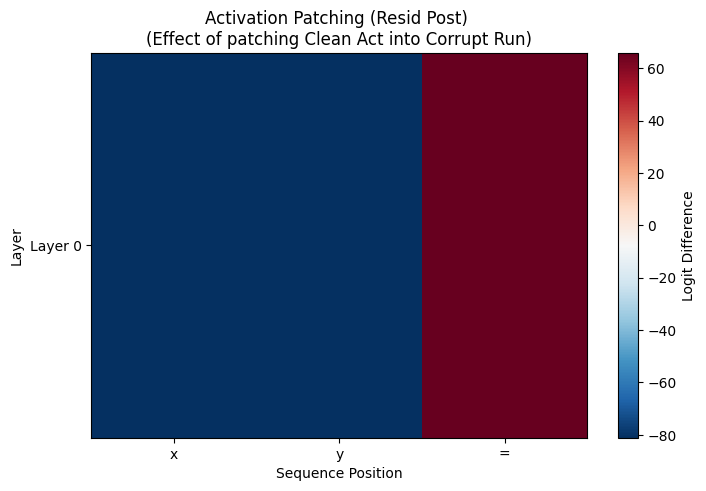

Moving model to device:  cpu
Clean Input: tensor([[ 69,  27, 113]]) Answer: 96
Corrupt Input: tensor([[ 53,  92, 113]]) Answer: 32
Baseline Logit Diff (Corrupted Run): -74.9533


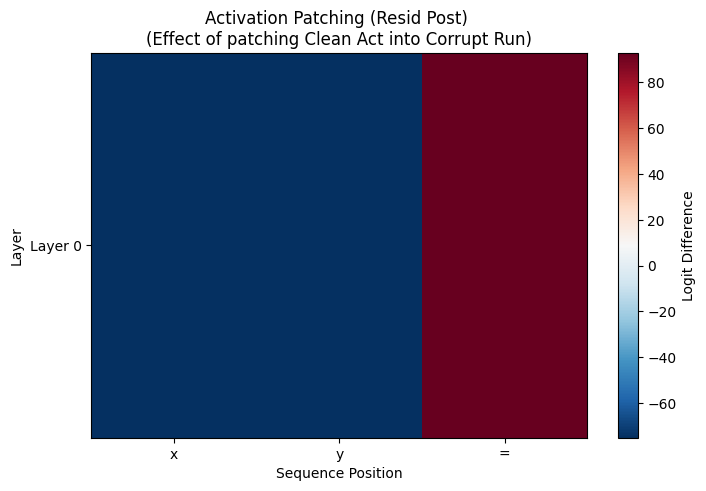

Moving model to device:  cpu
Clean Input: tensor([[ 14,  61, 113]]) Answer: 75
Corrupt Input: tensor([[ 34,  34, 113]]) Answer: 68
Baseline Logit Diff (Corrupted Run): -87.0976


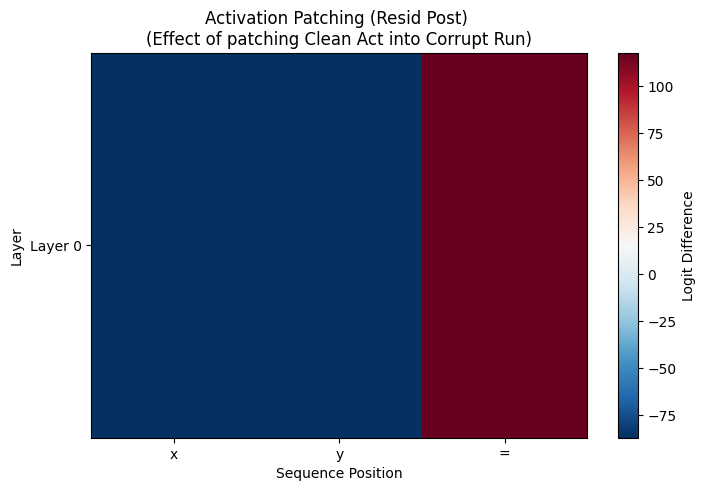

Moving model to device:  cpu
Clean Input: tensor([[109,   4, 113]]) Answer: 0
Corrupt Input: tensor([[ 42,  44, 113]]) Answer: 86
Baseline Logit Diff (Corrupted Run): -35.7639


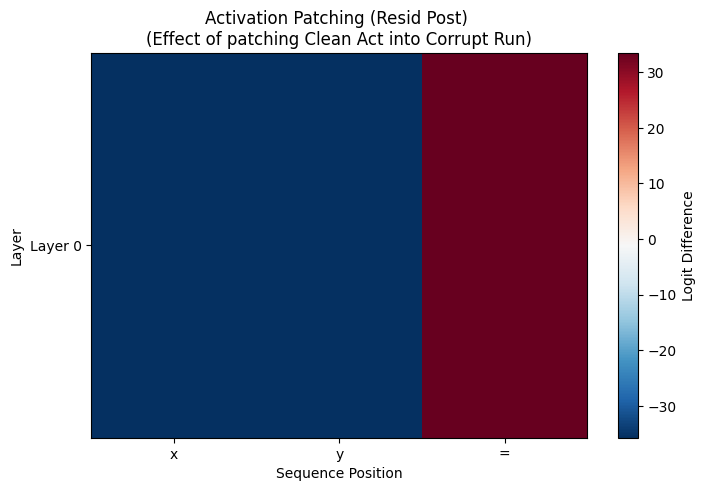

Moving model to device:  cpu
Clean Input: tensor([[ 69,  27, 113]]) Answer: 96
Corrupt Input: tensor([[ 53,  92, 113]]) Answer: 32
Baseline Logit Diff (Corrupted Run): -49.1260


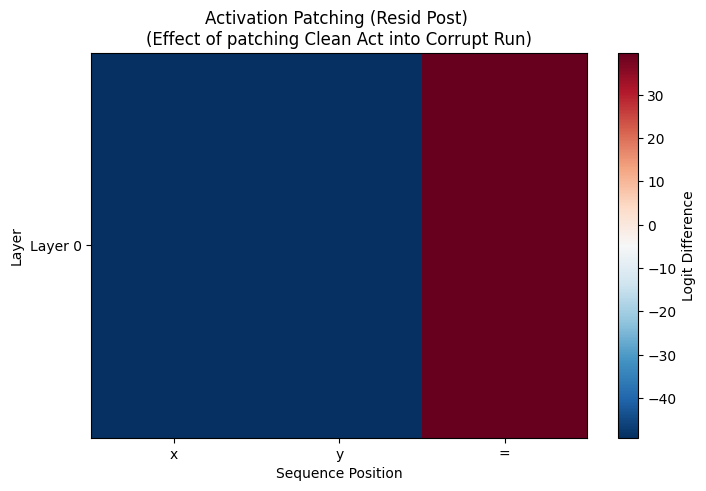

Moving model to device:  cpu
Clean Input: tensor([[ 65,  32, 113]]) Answer: 97
Corrupt Input: tensor([[ 30,  53, 113]]) Answer: 83
Baseline Logit Diff (Corrupted Run): -18.1109


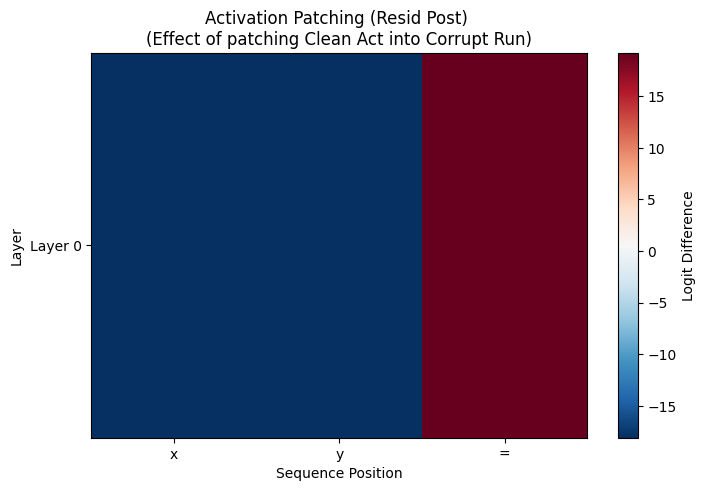

In [22]:
# ACTIVATION PATCHING CONT.

# Patching same models as the ones probed earlier
patch_dirs = {
    "Early1" : Path("runs") / "frac0.3_split0_mseed1",
    "Early2" : Path("runs") / "frac0.3_split2_mseed0",
    "Mid1"   : Path("runs") / "frac0.3_split0_mseed5",
    "Mid2"   : Path("runs") / "frac0.3_split0_mseed6",
    "Late1"  : Path("runs") / "frac0.3_split0_mseed0",
    "Late2"  : Path("runs") / "frac0.3_split0_mseed19"
}

# Dictionary to store results
patching_results = {}

for name, dir in patch_dirs.items():
    # Extract params from directory name
    train_fraction = float(str(dir.name).split("frac")[1].split("_")[0])
    split_seed = int(str(dir.name).split("split")[-1].split("_")[0])
    model_seed = int(str(dir.name).split("mseed")[-1])

    dataset, labels, _, _ = create_dataset(113, train_fraction, split_seed, "probe")
    model = HookedTransformer(create_model(113, model_seed)).to(device)

    # Load the trained model
    path = dir / "grok_model.pt"
    model.load_state_dict(t.load(path, map_location = device))

    # Patch
    result_matrix = run_activation_patching(model, dataset, labels)
    
    # Store result
    patching_results[name] = result_matrix
